<br> </br>
<font size = 8> <center> AI Strategy and Digital transformation </center> </font>
<font size = 6> <center>  <b> 4. Support vector machines </b> </center>
<br>
<font size = 5> <center> Piotr Wójcik </center> </font>
<font size = 5> <center> University of Warsaw, Poland
<font size = 5> <center> pwojcik@wne.uw.edu.pl
<br> </br>
<font size = 5> <center>  January 2025 </center> </font>
</center> </font>

In [1]:
# change working directory
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/szkolenia/2025-01_Bucharest'

Mounted at /content/drive
/content/drive/My Drive/szkolenia/2025-01_Bucharest


In [31]:
# lets import all the needed packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedKFold, GridSearchCV
from f_plot_roc_curve import *
from sklearn.svm import SVC # for Support Vector Classification

## Introduction to SVM based on fake data

In [3]:
# import some specific data

data1 = pd.read_csv("data/svm_sample_data1.csv")

data1.head()

,X1,X2,group
0,1.050270,0.964887,1
1,1.674606,0.111777,1
2,1.340385,0.655086,1
3,1.718744,0.368300,1
4,1.300403,-1.331239,1


<Axes: xlabel='X1', ylabel='X2'>

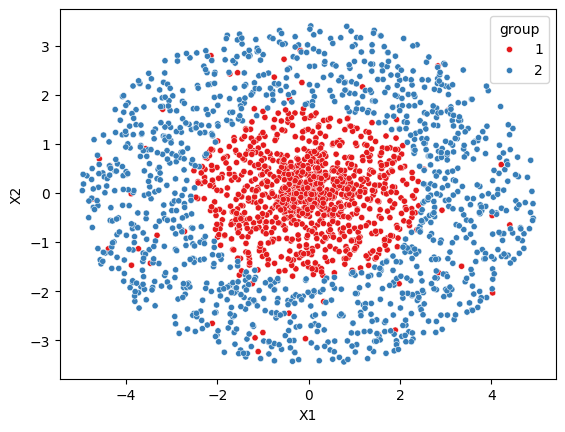

In [4]:
# and show the data on the plot

sns.scatterplot(
    data = data1,
    x = "X1",
    y = "X2",
    palette = "Set1",
    hue = "group",
    s = 20   # point size
)

In [5]:
# let's divide the data randomly into train and test samples
data1_train, data1_test = train_test_split(
    data1,
    test_size = 0.3,
    stratify = data1['group'],
    random_state = 123) # keep constant for reproducibility

In [6]:
# check the frequencies of the variable group

data1['group'].value_counts()

,count
group,
2,1150
1,1050


## SVM with a linear kernel (linear)

In [7]:
# Split into features (X) and target (y)
X_train = data1_train[['X1', 'X2']]
y_train = data1_train['group']

# Create an SVM model with a linear kernel
svm_linear = SVC(kernel = 'linear') # by default C = 1.0

# Fit (train) the SVM model on the training data
svm_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [8]:
# lets generate forecasts for the test set

data1_test["fore_svm_Linear"] = svm_linear.predict(data1_test[["X1", "X2"]])

data1_test.head()

,X1,X2,group,fore_svm_Linear1
46,-1.231920,-0.181032,1,2
467,2.042157,0.509390,1,2
244,1.436009,-0.619451,1,2
218,0.776901,-0.269748,1,2
997,-0.556233,-0.130546,1,2


In [9]:
# Frequency table of the forecasts

data1_test["fore_svm_Linear"].value_counts()

# all observations predicted as group 2!

,count
fore_svm_Linear1,
2,660


In [19]:
# confusion matrix
confusion_matrix(data1_test["group"],
                 data1_test["fore_svm_Linear"])

array([[  0, 315],
       [  0, 345]])

In [22]:
# classification report
print(classification_report(
       data1_test["group"],
       data1_test["fore_svm_Linear"],
       zero_division = 0))

# very bad...

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       315
           2       0.52      1.00      0.69       345

    accuracy                           0.52       660
   macro avg       0.26      0.50      0.34       660
weighted avg       0.27      0.52      0.36       660



## SVM with a linear kernel (linear) - hyperparameter tuning

In [41]:
# the linear kernel has only one hyperparameter - C - the cost

# lets try different values of C with repeated cross-validation

cv5x3 = RepeatedKFold(n_splits = 5,
                      n_repeats = 3,
                      random_state = 123)

# the grid of parameters has to be defined as a dict() object which element name(s)
# are the same as parameters of the algorithm

svm_linear_grid = {'C': [0.001, 0.01, 0.02, 0.05,
                        0.1, 0.2, 0.5, 1, 2, 5, 10]}

# Set up of GridSearchCV
svm_linear_tuned = GridSearchCV(
    estimator = svm_linear, # defined above
    param_grid = svm_linear_grid,
    scoring = 'roc_auc',
    cv = cv5x3,
    n_jobs = -1)  # Use all available CPU cores (optional)

# Fit on training data
svm_linear_tuned.fit(X_train, y_train)

# Print or inspect the best parameters and scores
print("Best C:", svm_linear_tuned.best_params_)
print("Best AUC:", svm_linear_tuned.best_score_)


Best C: {'C': 5}
Best AUC: 0.5044425381529721


In [43]:
# optimal C = 5 - lets check performance of the tuned model

data1_test["fore_svm_Linear_tuned"] = svm_linear_tuned.predict(data1_test[["X1", "X2"]])

# classification report
print(classification_report(
       y_true = data1_test["group"],
       y_pred = data1_test["fore_svm_Linear_tuned"],
       zero_division = 0))

# still bad - predicting just one class (2)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       315
           2       0.52      1.00      0.69       345

    accuracy                           0.52       660
   macro avg       0.26      0.50      0.34       660
weighted avg       0.27      0.52      0.36       660



## SVM with a polynomial kernel (poly)

In [50]:
# lets check the polynomial kernel, which has more parameters
# - C - same as before (Cost of errors)
# - degree - degree of a polynomial
# - scale/gamma - scaling parameter in the transformation
#           k(x,y) = (scale*x'y + coef)^degree

# Create an SVM model with a polynomial kernel
svm_poly = SVC(kernel = 'poly', # by default C = 1.0
               max_iter = 20000)  # to get the result faster - instead of default unlimited -1
                                  # otherwise it runs very long

# the grid of parameters has to be defined as a dict() object which element name(s)
# are the same as parameters of the algorithm
svm_poly_grid = {'C': [0.001, 1, 5],
                 'degree': [2, 3, 4, 5],
                 'gamma': [1.0], # lets use just 1 here
                 'coef0': [1.0]} # lets keep the value of 1 here

# lets use simpler CV method
cv5 = KFold(n_splits = 5,
            shuffle = True,
            random_state = 123)

# Set up of GridSearchCV
svm_poly_tuned = GridSearchCV(
    estimator = svm_poly, # defined above
    param_grid = svm_poly_grid,
    scoring = 'roc_auc',
    cv = cv5,
    n_jobs = -1)  # Use all available CPU cores (optional)

# Fit on training data
svm_poly_tuned.fit(X_train, y_train)

# Print or inspect the best parameters and scores
print("Best parameters:", svm_poly_tuned.best_params_)
print("Best AUC:", svm_poly_tuned.best_score_)


Best C: {'C': 1, 'coef0': 1.0, 'degree': 2, 'gamma': 1.0}
Best AUC: 0.973038465552378


In [51]:
# optimal C = 1, degree = 2 - lets check performance of the tuned model

data1_test["fore_svm_poly_tuned"] = svm_poly_tuned.predict(data1_test[["X1", "X2"]])

# classification report
print(classification_report(
       y_true = data1_test["group"],
       y_pred = data1_test["fore_svm_poly_tuned"],
       zero_division = 0))

# looks MUCH BETTER than the linear!

              precision    recall  f1-score   support

           1       0.97      0.97      0.97       315
           2       0.97      0.97      0.97       345

    accuracy                           0.97       660
   macro avg       0.97      0.97      0.97       660
weighted avg       0.97      0.97      0.97       660



## SVM with a Radial Basis kernel (rbs)

In [68]:
# let's swich to radial basis kernel (gaussian), which has two parameters:
# - C - as before
# - gamma  - scaling parameter
#           k(x,y) = exp(-gamma||x-y||^2))

# Define the SVC model with an RBF kernel
svm_rbf = SVC(kernel = 'rbf',  # radial basis function
              max_iter = 20000) # limit iterations for faster convergence

# Define a grid of hyperparameters
svm_rbf_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100],
    'gamma': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 100]}

# Set up GridSearchCV with cv5
svm_rbf_tuned = GridSearchCV(
    estimator = svm_rbf,
    param_grid = svm_rbf_grid,
    scoring = 'roc_auc',
    cv = cv5,
    n_jobs = -1)  # Use all available cores for parallelism

# Fit on the training data
svm_rbf_tuned.fit(X_train, y_train)

# Print the best parameters and scores
print("Best parameters:", svm_rbf_tuned.best_params_)
print("Best AUC:", svm_rbf_tuned.best_score_)


Best parameters: {'C': 1, 'gamma': 10}
Best AUC: 0.9735577597103499


In [69]:
# optimal C = 5, gamma = 0.05 - lets check performance of the tuned model

data1_test["fore_svm_rbf_tuned"] = svm_rbf_tuned.predict(data1_test[["X1", "X2"]])

# classification report
print(classification_report(
       y_true = data1_test["group"],
       y_pred = data1_test["fore_svm_rbf_tuned"],
       zero_division = 0))

# The BEST so far :)

              precision    recall  f1-score   support

           1       0.99      0.95      0.97       315
           2       0.95      0.99      0.97       345

    accuracy                           0.97       660
   macro avg       0.97      0.97      0.97       660
weighted avg       0.97      0.97      0.97       660



# Comparison on data 2

<Axes: xlabel='X1', ylabel='X2'>

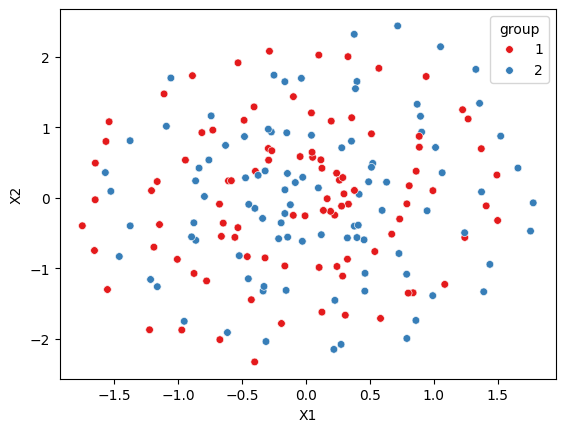

In [70]:
# we can check the same on even more complex spiral data of the same structure (X1, X2, group)
data2 = pd.read_csv("data/svm_sample_data2.csv")

#  show the data on the plot
sns.scatterplot(
    data = data2,
    x = "X1",
    y = "X2",
    palette = "Set1",
    hue = "group",
    s = 30)  # point size

# looks like it is totally mixed, but after a second look one can see some spiral structure

In [71]:
# # let's divide the data randomly into train and test samples

data2_train, data2_test = train_test_split(
    data2,
    test_size = 0.3,
    stratify = data2['group'],
    random_state = 123) # keep constant for reproducibility

# and prepare for modelling by splitting into features (X) and target (y)
X_train2 = data2_train[['X1', 'X2']]
y_train2 = data2_train['group']


In [73]:
# then lets tune three SVC models with various kernel functions: linear, polynomial and rbf

# for simplicity we are using the same grids of hyperparameters as before

#-------------------------------------------------
# linear

svm_linear2 = SVC(kernel = 'linear', max_iter = 20000)

svm_linear2_tuned = GridSearchCV(
    estimator = svm_linear2,
    param_grid = svm_linear_grid, # same as before
    scoring = 'roc_auc',
    cv = cv5, # lets use cv5
    n_jobs = -1)  # Use all available CPU cores (optional)

# Fit on training data
svm_linear2_tuned.fit(X_train2, y_train2)

# Print or inspect the best parameters and scores
print("Best C for linear:", svm_linear2_tuned.best_params_)
print("Best AUC for linear:", svm_linear2_tuned.best_score_)


#-------------------------------------------------
# poly

svm_poly2 = SVC(kernel = 'poly', max_iter = 20000)

svm_poly2_tuned = GridSearchCV(
    estimator = svm_poly2,
    param_grid = svm_poly_grid, # same as before
    scoring = 'roc_auc',
    cv = cv5,
    n_jobs = -1)  # Use all available CPU cores (optional)

# Fit on training data
svm_poly2_tuned.fit(X_train2, y_train2)

# Print or inspect the best parameters and scores
print("Best parameters for poly:", svm_poly2_tuned.best_params_)
print("Best AUC for poly:", svm_poly2_tuned.best_score_)

#-------------------------------------------------
# rbf
svm_rbf2 = SVC(kernel = 'rbf', max_iter = 20000)

svm_rbf2_tuned = GridSearchCV(
    estimator = svm_rbf2,
    param_grid = svm_rbf_grid, # same as before
    scoring = 'roc_auc',
    cv = cv5,
    n_jobs = -1)  # Use all available cores for parallelism

# Fit on the training data
svm_rbf2_tuned.fit(X_train2, y_train2)

# Print the best parameters and scores
print("Best parameters for rbs:", svm_rbf2_tuned.best_params_)
print("Best AUC for rbs:", svm_rbf2_tuned.best_score_)

Best C for linear: {'C': 2}
Best AUC for linear: 0.5311191523579775
Best parameters for poly: {'C': 0.001, 'coef0': 1.0, 'degree': 3, 'gamma': 1.0}
Best AUC for poly: 0.549058464594863
Best parameters for rbs: {'C': 5, 'gamma': 100}
Best AUC for rbs: 0.9269799205335602


In [74]:
# having estimated three models lets directly compare their performance

# We'll store them in a dictionary:
models = {
    "Linear SVM": svm_linear2_tuned,
    "Polynomial SVM": svm_poly2_tuned,
    "RBF SVM": svm_rbf2_tuned}

# Create a list to gather results
results = []

# Loop over each model, retrieve best score & best parameters
for model_name, grid_obj in models.items():
    best_score = grid_obj.best_score_  # in our case best AUC

    # Build a row containing the info
    row = {"Model": model_name, "Best Score": best_score}

    # Append to results list
    results.append(row)

# Convert to a pandas DataFrame for easy viewing
comparison_df = pd.DataFrame(results)

# Sort by best score (descending) if desired
comparison_df.sort_values(by = "Best Score", ascending = False, inplace = True)

# Display the comparison table
print(comparison_df)

# although a linear and polynomial kernel are weak, the rbs result looks promising :)
# here optimal gamma is relatively large (100 - see above), which shows that
# one should always try to cover a wide range of the values of hyperparameters

            Model  Best Score
2         RBF SVM    0.926980
1  Polynomial SVM    0.549058
0      Linear SVM    0.531119


# Exercises 4

* Apply SVM algorithm with various kernel functions (linear, polynomial and rbs) on the churn `dataset`.
* Add scaling of the variables to z-scores into the models' pipeline
* Find optimal values of respective hyperparameters and check the performance of the best models on test data

In [ ]:
# lets load the imputed churn data stored before
with open('data/churn_prepared.pkl', 'rb') as f:  # 'rb' stands for read in a binary mode
    churn_train_encoded = pickle.load(f)
    churn_test_encoded = pickle.load(f)

churn_test_encoded.head()

,Order,PID,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,...,Sale_Type_COD,Sale_Type_ConLD,Sale_Type_New,Sale_Type_Othr,Sale_Type_WD,Sale_Condition_Abnorml,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,1,526301100,141,31770,1960,1960,112,2,0,441,...,0,0,0,0,1,0,0,0,1,0
1,2,526350040,80,11622,1961,1961,0,6,144,270,...,0,0,0,0,1,0,0,0,1,0
2,3,526351010,81,14267,1958,1958,108,1,0,406,...,0,0,0,0,1,0,0,0,1,0
3,4,526353030,93,11160,1968,1968,0,1,0,1045,...,0,0,0,0,1,0,0,0,1,0
4,5,527105010,74,13830,1997,1998,0,3,0,137,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
# here is the place to include the solution of exercises 4